<a href="https://colab.research.google.com/github/villafue/LinkedIn_Python_Stastics_Essential_Training/blob/master/05_04_crossvalidation_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Python statistics essential training - 05_04_crossvalidation

Standard imports

In [ ]:
'''
In this unit, he's going to show us how to implement a much simpler strategy known
as Cross Validation which is used in Machine Learning to compare models.

We divide the data into a training set which we use to feed the model, and a
testing set which we use to evaluate the models prediction error.

So instead of concentrating on in-sample error as we do with classical techniques,
we will look at out of (or how to?) sample prediction error. Models then can't
look better by over fitting the data they're trained on. Instead, they need to,
in some sense, understand something about the world.  
'''

In [ ]:
import math
import os

In [ ]:
os.chdir('sample_data')

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline

In [ ]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Loading gapminder data for year 1985 (Live Aid!).

In [ ]:
gapminder = pd.read_csv('gapminder.csv')

In [ ]:
gdata = gapminder.query('year == 1985')

Refactored plotting so that it works on arbitrary datasets.

In [ ]:
'''
The following code is because we will be splitting our data.
'''
def sc(data):
    return 1e-6 * data.population, data.region.map({'Africa': 'skyblue', 'Europe': 'gold',
                                                   'America': 'palegreen', 'Asia': 'coral'})

def plotdata(data=gdata):
    size, colors = sc(data)
    data.plot.scatter('age5_surviving','babies_per_woman',
                      c=colors,s=size,linewidths=0.5,edgecolor='k',alpha=0.5)
                      
def plotfit(fit,data=gdata):
    plotdata(data)

    size, colors = sc(data)
    plt.scatter(data.age5_surviving,fit.predict(data),
               c=colors,s=30,linewidths=0.5,edgecolor='k',marker='D')

Model formulas from the last two videos

In [ ]:
f_groupmeans = 'babies_per_woman ~ -1 + region'
f_surviving = 'babies_per_woman ~ -1 + region + age5_surviving'
f_srp = ('babies_per_woman ~ -1 + region + age5_surviving'
         '+ age5_surviving:region - age5_surviving + population')

In [ ]:
'''
To divide our data, we're first going to shuffle it using pandas method .sample.
The resulting dataset should be the same length as the original. Also, there is
no replacement.
'''
shuffled = gdata.sample(len(gdata))
display(shuffled.head())

,country,year,region,population,life_expectancy,age5_surviving,babies_per_woman,gdp_per_capita,gdp_per_day
6933,Kiribati,1985,Asia,64006.0,56.04,88.51,4.86,1531.0,4.191650
9687,Nicaragua,1985,America,3709091.0,68.89,91.73,5.43,4112.0,11.258042
7743,Libya,1985,Africa,3840635.0,71.09,94.56,6.58,35825.0,98.083504
2885,Colombia,1985,America,31011686.0,70.48,95.77,3.43,6613.0,18.105407
7419,Latvia,1985,Europe,2582079.0,69.72,97.90,2.13,12448.0,34.080767


In [ ]:
'''
Then we use the pandas iloc, which goes by row number, to divide the rows in two.
Integer division "//" ensures I have a proper index.
'''
training, testing = shuffled.iloc[:len(gdata)//2], shuffled.iloc[len(gdata)//2:]

In [ ]:
display(training.head())
testing.head()

,country,year,region,population,life_expectancy,age5_surviving,babies_per_woman,gdp_per_capita,gdp_per_day
6933,Kiribati,1985,Asia,64006.0,56.04,88.51,4.86,1531.0,4.191650
9687,Nicaragua,1985,America,3709091.0,68.89,91.73,5.43,4112.0,11.258042
7743,Libya,1985,Africa,3840635.0,71.09,94.56,6.58,35825.0,98.083504
2885,Colombia,1985,America,31011686.0,70.48,95.77,3.43,6613.0,18.105407
7419,Latvia,1985,Europe,2582079.0,69.72,97.90,2.13,12448.0,34.080767


,country,year,region,population,life_expectancy,age5_surviving,babies_per_woman,gdp_per_capita,gdp_per_day
2480,Cape Verde,1985,Africa,313976.0,66.12,92.20,5.88,1469.0,4.021903
7824,Lithuania,1985,Europe,3563741.0,70.78,98.09,2.06,16510.0,45.201916
10578,Poland,1985,Europe,37486105.0,70.78,97.97,2.27,11159.0,30.551677
7338,Lao,1985,Asia,3680145.0,48.54,81.82,6.36,1616.0,4.424367
5394,Guinea,1985,Africa,5078689.0,47.33,73.69,6.64,1085.0,2.970568


In [ ]:
'''
We now fit a model to the training data using one of our formulas.
'''
surviving = smf.ols(f_surviving, data=training).fit()

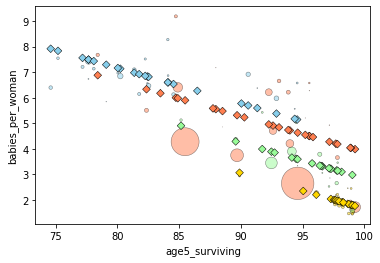

In [ ]:
'''
We plot the result.
'''
plotfit(surviving,training)

In [ ]:
'''
The in-sample mean squared error is .95
'''
surviving.mse_resid

0.9558127329559172

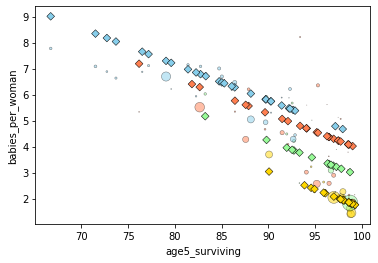

In [ ]:
'''
We now try out the model on the testing data. Plotfit contains a call to stats
model predict which generates a moderate response for this particular data set.
We see the datapoints are different but the fit is comparable to the one above.
'''
plotfit(surviving,testing)

In [ ]:
'''
To obtain the Mean Squared Error, we have to do a little work. We first compute
the residuals by applying modern prediction to the testing data set. We then subtract
the observed data.

The second line of code computes the number of degrees of freedom which is the
length of the data minus the number of parameters in the model minus 1 since the
number of parameters doesn't count the constant, but we should.

Finally, we square the residuals, sum them, and divide by the number of degrees
of freedom.

The Mean Squared Error on the testing data is a little higher since now there's
no overfitting.
'''
resid = surviving.predict(testing) - testing.babies_per_woman
df = len(testing) - surviving.df_model - 1
np.sum(resid**2) / df

1.0513806295689143

In [ ]:
'''
Now we're going to automate this procedure and use it on the three models. Since
the results depend on the shuffling and are rather noisy, we'll repeat a few times
and take the average.

The function is generic in terms of the formula, response variable we're looking
at, and the number of repetitions. We also add a spot for data.

In essence, we shuffle, divide in 2, we train, and we compute MeanSquaredError.
We grab an arbitrary response variable column, and finally, collect all the response
variable columns in a Python list. Last, we return its average.
'''

def cross_validate(data,formula,response,n=100):
    ret = []
    
    for i in range(n):
        shuffled = data.sample(len(data))
        
        training, testing = shuffled.iloc[:len(data)//2], shuffled.iloc[len(data)//2:]
        
        trained = smf.ols(formula, data=training).fit()
        
        resid = trained.predict(testing) - testing[response]
        df = len(testing) - trained.df_model - 1
        mse = np.sum(resid**2) / df
        
        ret.append(mse)
    
    return np.mean(ret)

In [ ]:
'''
Now we're going to try this out on our models. The response variable is always
babies per woman.
'''
cross_validate(gdata,f_groupmeans,'babies_per_woman')

1.6301501574871873

In [ ]:
cross_validate(gdata,f_surviving,'babies_per_woman')

1.041360665285817

In [ ]:
cross_validate(gdata,f_srp,'babies_per_woman')

1.2139253615712926

In [ ]:
'''
Cross validation confirms the verdict of analytical goodness of fit measures. The
model of intermediate complexity (f_surviving which is the 2nd one), seems to hit
the sweet spot in terms of explanatory power.

In the real world, Data Analysts use k-fold cross validation. Instead of dividing
the data in two, we divide it in k-subsets, and then k-successive trials, we hold
out one of the subsets for testing and trains on all the rest. Finally, the k-resulting
models are averaged. K-fold cross validation is supported in Scikit-learn.
'''